12.6 첫번째 예시 : 완전한 백테스트

In [1]:
from data_processing import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#Chap 1 데이터

data_raw = pd.read_csv('data_ml.csv')
idx_date = data_raw.index[(
    data_raw['date'] > '1999-12-31') & (
    data_raw['date'] < '2019-01-01')].tolist()

#날짜를 받기 위한 인덱스 생성
data_ml = data_raw.iloc[idx_date]
#날짜 인덱스에 따라 데이터셋 필터링
data_ml.iloc[0:6, 0:6]

features = list(data_ml.iloc[:, 3:95].columns)
# 특성의 열 이름 저장 
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd",
                  "Mom_11M_Usd", "Ocf", "Pb", "Vol1Y_Usd"]

separation_date = "2014-01-15"
idx_train = data_ml.index[(data_ml['date']<separation_date)].tolist()
idx_test = data_ml.index[(data_ml['date']>=separation_date)].tolist()

stock_ids_short = []
stock_days = []

# 각 주식별 데이터 포인트 개수 세기
stock_ids = data_ml['stock_id'].unique()
stock_days = data_ml[['date', 'stock_id']].groupby(
    ['stock_id']).count().reset_index()

# 데이터가 모두 있는 주식을 리스트로 변환
stock_ids_short = stock_days.loc[
    stock_days['date'] == (stock_days['date'].max())]
stock_ids_short = stock_ids_short['stock_id'].unique()
is_stock_ids_short = data_ml['stock_id'].isin(stock_ids_short)
returns = data_ml[is_stock_ids_short].pivot(
    index='date', columns='stock_id', values='R1M_Usd'
)

1. 변수 생성 및 초기화

In [2]:
import datetime as dt
from datetime import datetime
sep_oos = "2007-01-01" #백테스트 시작 시점
ticks = list(data_ml['stock_id'].unique()) # 모든 자산들 식별 코드 리스트
N = len(ticks) #최대 자산 개수
t_oos = list(returns.index[returns.index>sep_oos].values) #표본 외 날짜
t_as = list(returns.index.values) #전체 날짜
Tt = len(t_oos) #날짜 개수
nb_port = 2 #포트폴리오 전략 개수

#포트폴리오 가중치 및 수익률 초기화
portf_weights = np.zeros(shape=(Tt, nb_port, max(ticks)+1))
portf_returns = np.zeros(shape=(Tt, nb_port))

2. 메인 함수에서 전략 정의

In [3]:
import xgboost as xgb
# XGB, EW 
def weights_xgb(train_data, test_data, features):
    # 독립 변수
    train_features = train_data[features]
    train_label = train_data['R12M_Usd'] / np.exp(train_data['Vol1Y_Usd'])
    # 종속 변수
    ind = (train_label < np.quantile(
        train_label, 0.2)) | (train_label > np.quantile(train_label, 0.8)) # 범위 필터
    train_features = train_features.loc[ind]
    train_label = train_label.loc[ind]
    train_matrix = xgb.DMatrix(train_features, label=train_label)
    params={'eta':0.3,
            'objective':'reg:squarederror',
            'max_depth':4}
    fit_xgb = xgb.train(params, train_matrix, num_boost_round=80)
    
    test_features = test_data[features]
    test_matrix = xgb.DMatrix(test_features)
    pred = fit_xgb.predict(test_matrix)
    w_names = test_data["stock_id"]
    w = pred > np.median(pred)
    w = w / np.sum(w)
    return w, w_names

In [4]:
# 동일가중 포트폴리오
def portf_compo(train_data, test_data, features, j):
    if j == 0: #벤치마크
        N = len(test_data['stock_id'])
        w = np.repeat(1/N,N)
        w_names = test_data['stock_id']
        return w, w_names
    elif j == 1:
        return weights_xgb(train_data, test_data, features)

In [5]:
m_offset = 12 # 버퍼 기간을 위한 오프셋 
train_size = 5 # 훈련셋 사이즈 연수
for t in range(len(t_oos)-1): #선도 수익률 금지
    ind = (
        data_ml['date'] < datetime.strftime(
            datetime.strptime(t_oos[t], "%Y-%m-%d") - dt.timedelta(m_offset*30), "%Y-%m-%d")) & (
        data_ml['date'] > datetime.strftime(
            datetime.strptime(t_oos[t], "%Y-%m-%d") - dt.timedelta(m_offset*30) - dt.timedelta(365 * train_size), "%Y-%m-%d"))
    train_data = data_ml.loc[ind,:]
    test_data = data_ml.loc[data_ml['date'] == t_oos[t], :]
    realized_returns = test_data["R1M_Usd"]
    
    # 1개월 홀딩 기간을 고려한 수익률 계산
    for j in range(nb_port):
        temp_weights, stocks = portf_compo(
            train_data, test_data, features, j)
        portf_weights[t, j, stocks] = temp_weights
        portf_returns[t,j] = np.sum(temp_weights * realized_returns) #수익률 계산

In [6]:
# 회전율 계산 함수
def turnover(weights, asset_returns, t_oos):
    turn = 0
    for t in range(1, len(t_oos)):
        realized_returns = asset_returns[returns.index == t_oos[t]].values
        prior_weights = weights[t-1] * (1+realized_returns)
        turn = turn + np.sum(np.abs(
            weights[t] - prior_weights/np.sum(prior_weights)))
    return turn / (len(t_oos) - 1)

In [7]:
# 주요 지표 계산 함수
def perf_met(portf_returns, weights, asset_returns, t_oos):
    avg_ret = np.nanmean(portf_returns) # 산술평균
    vol = np.nanstd(portf_returns, ddof=1) # 변동성
    Sharpe_ratio = avg_ret / vol #샤프비율
    VaR_5 = np.quantile(portf_returns, 0.05) #VaR
    turn = turnover(weights, asset_returns, t_oos) #회전율
    met = [avg_ret, vol, Sharpe_ratio, VaR_5, turn]
    return met

In [8]:
# 다양한 전략 반복
def perf_met_multi(portf_returns, weights, asset_returns, t_oos, strat_name):
    J = weights.shape[1]
    met = []
    for j in range(J):
        temp_met = perf_met(portf_returns[:, j], weights[:,j,:], asset_returns, t_oos)
        met.append(temp_met)
    return pd.DataFrame(met, index=strat_name, columns = ['avg_ret', 'vol', 'Sharpe_ratio', 'VaR_5', 'turn'])

In [9]:
asset_returns = data_ml[['date', 'stock_id', 'R1M_Usd']].pivot(
    index='date', columns='stock_id', values='R1M_Usd')
na = list(set(np.arange(
    max(asset_returns.columns)+1)).difference(set(asset_returns.columns)))
asset_returns[na] = 0
asset_returns = asset_returns.loc[:, sorted(asset_returns.columns)]
asset_returns.fillna(0, inplace=True)
perf_met_multi(portf_returns, portf_weights, asset_returns, t_oos, strat_name=["EW","XGB_SR"])

,avg_ret,vol,Sharpe_ratio,VaR_5,turn
EW,0.009697,0.056429,0.171848,-0.077125,0.071451
XGB_SR,0.012585,0.063219,0.199066,-0.087143,0.563090


C:\Users\Administrator\AppData\Local\Temp\ipykernel_33256\3239909270.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  g2[["benchmark", "ml_based"]].pct_change(1).plot.bar(figsize=[16,6], ylabel = 'Yearly performance')


<Axes: xlabel='date', ylabel='Yearly performance'>

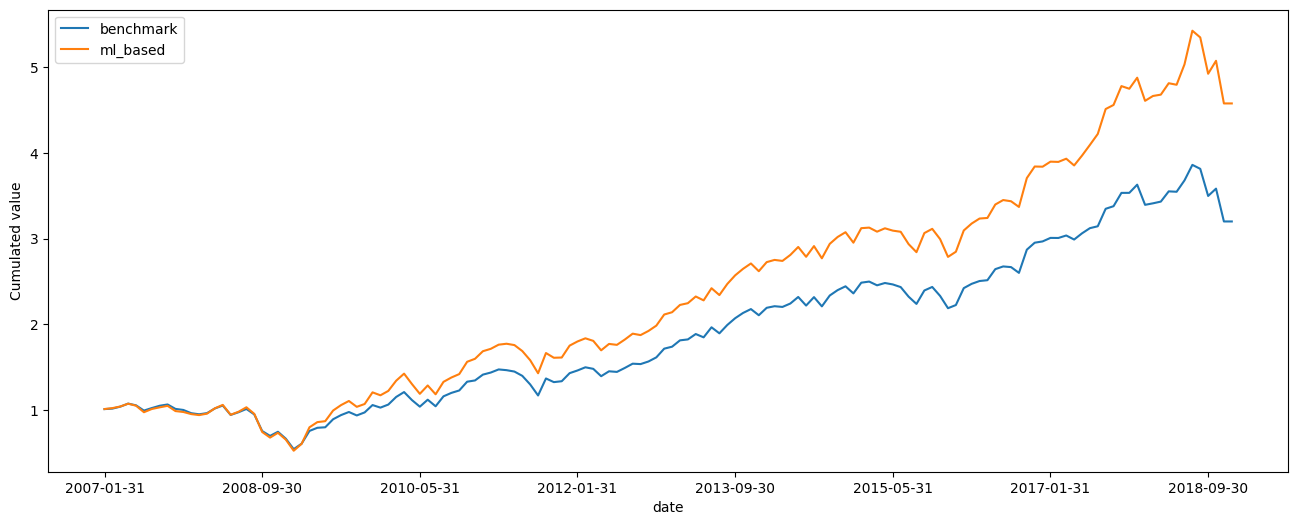

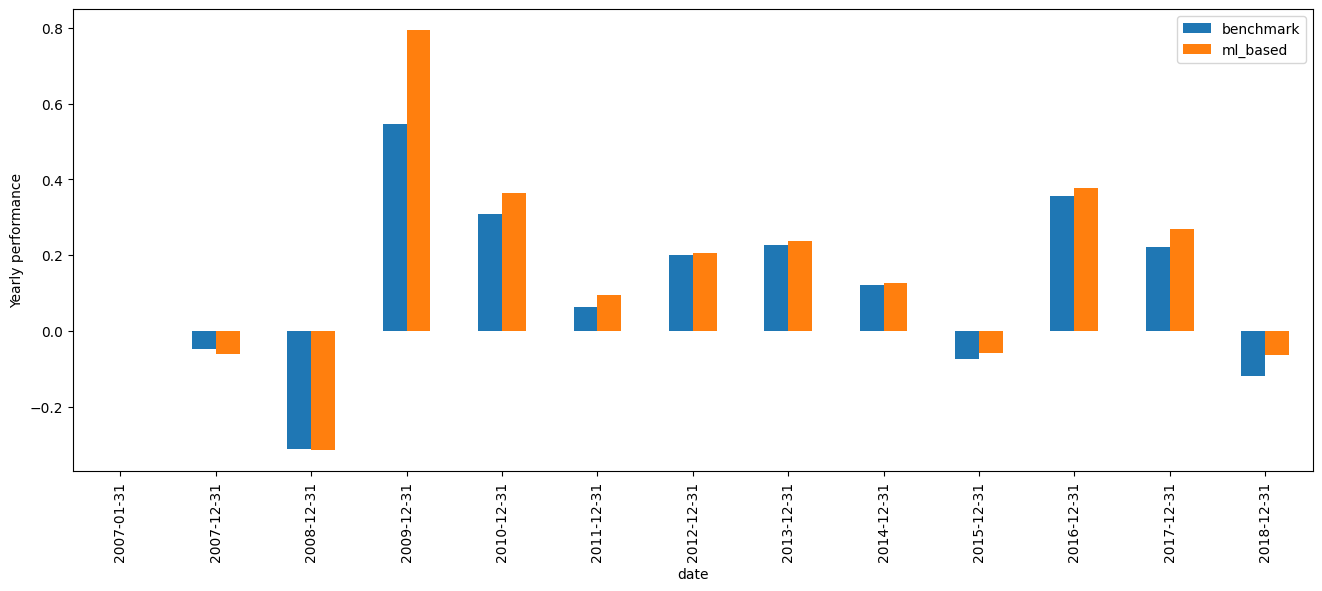

In [10]:
#그래프
g1 = pd.DataFrame(
    [t_oos, np.cumprod(
        1+portf_returns[:,0]), np.cumprod(
        1+portf_returns[:,1])], index = ["date", "benchmark", "ml_based"]).T
g1.reset_index(inplace=True)

g1['date_month'] = pd.to_datetime(g1['date']).dt.month
g1.set_index('date', inplace=True)
g2 = g1[g1['date_month'] == 12]
g2 = pd.concat([g2, g1.iloc[[0]]])
g2.sort_index(inplace=True)

g1[["benchmark", "ml_based"]].plot(figsize=[16,6], ylabel='Cumulated value')
g2[["benchmark", "ml_based"]].pct_change(1).plot.bar(figsize=[16,6], ylabel = 'Yearly performance')

12.7 두번째 예시 : 백테스트 과최적화

In [12]:
def strat(data, feature, thresh, direction):
    data_tmp = data[[feature, 'date', 'R1M_Usd']].copy()
    data_tmp['decision'] = direction*data_tmp[feature] > direction*thresh
    data_tmp = data_tmp.groupby('date').apply(
        lambda x: np.sum(x['decision']/np.sum(x['decision'])*x['R1M_Usd']) #자산기여도, 가중치*수익률
    )
    avg = np.nanmean(data_tmp) #포트폴리오 평균수익률
    sd = np.nanstd(data_tmp, ddof=1) #연율화 되지 않은 포트폴리오 변동성
    SR = avg / sd #샤프비율
    return np.around([avg, sd, SR],4)

In [13]:
strat(data_ml, "Pb", 0.3, 1) #분포의 0.3 사분위수보다 높은 Pb 매수

C:\Users\Administrator\AppData\Local\Temp\ipykernel_33256\2751626241.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_tmp = data_tmp.groupby('date').apply(


array([0.0102, 0.0496, 0.2065])

In [14]:
import itertools
feature = ['Div_Yld', 'Ebit_Bv', 'Mkt_Cap_6M_Usd', 'Mom_11M_Usd', 'Pb', 'Vol1Y_Usd']
thresh = np.arange(0.2, 0.9, 0.1)
direction =np.array([1,-1])

C:\Users\Administrator\AppData\Local\Temp\ipykernel_33256\2751626241.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_tmp = data_tmp.groupby('date').apply(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_33256\2751626241.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_tmp = data_tmp.groupby('date').apply(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_33256\2751626241.py:4: Depreca

<Axes: xlabel='thresh', ylabel='Direction = 1'>

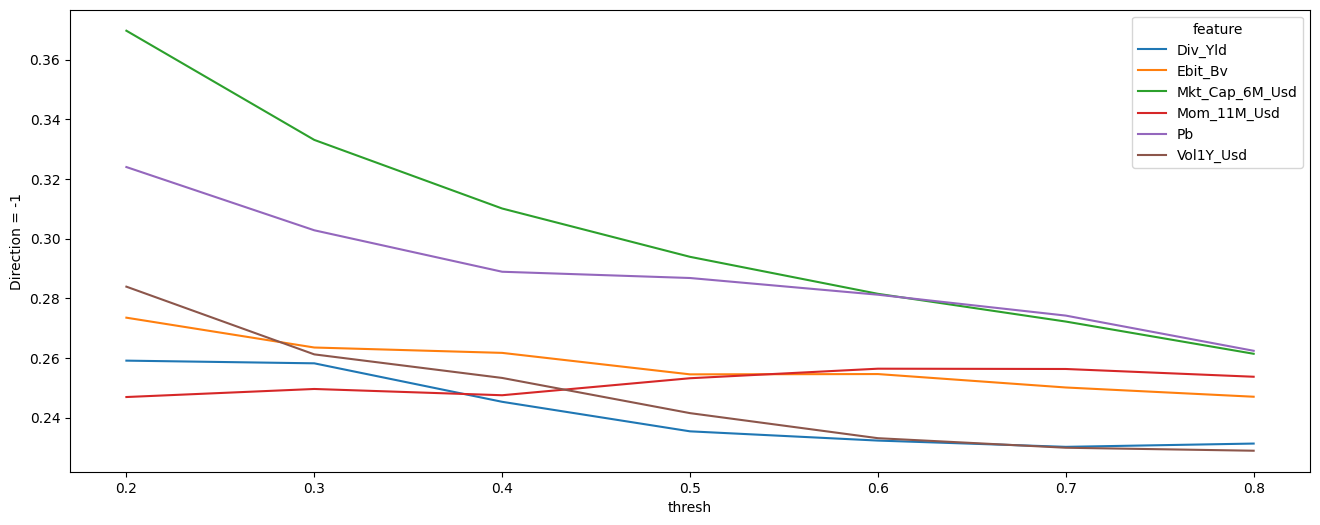

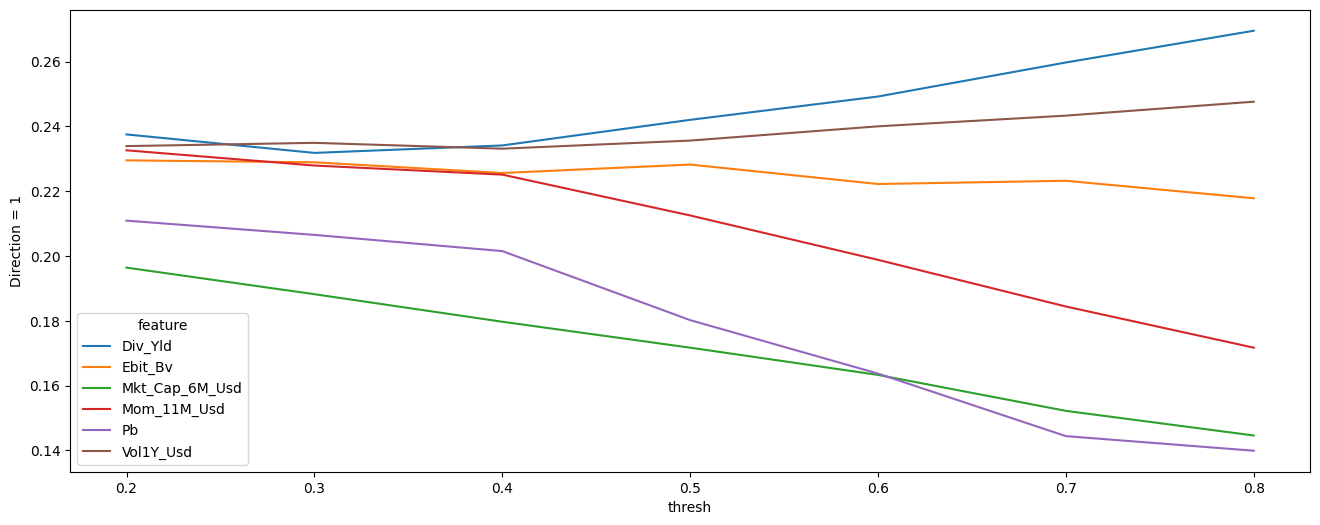

In [16]:
grd = []
for f, t, d in itertools.product(feature, thresh, direction):
    strat_data = []
    strat_data = pd.DataFrame(strat(data_ml, f, t, d)).T
    strat_data.rename(columns={0: 'avg', 1: 'sd', 2: 'SR'}, inplace=True)
    strat_data[['feature', 'thresh', 'direction']] = f, t, d
    grd.append(strat_data)
grd = pd.concat(grd)[['feature', 'thresh', 'direction', 'avg', 'sd', 'SR']]

grd[grd['direction']==-1].pivot(index='thresh', columns='feature', values='SR').plot(figsize=[16,6], ylabel='Direction = -1')
grd[grd['direction']==1].pivot(index='thresh', columns='feature', values='SR').plot(figsize=[16,6], ylabel='Direction = 1')


In [19]:
from scipy import special as special
from scipy import stats as stats

def DSR(SR, Tt, M, g3, g4, SR_m, SR_v):
    gamma = -special.digamma(1) # 오일러-마스케로니 상수
    SR_star = SR_m + np.sqrt(SR_v) * ((1-gamma)*stats.norm.ppf(1-1/M)+gamma*stats.norm.ppf(1-1/M/np.exp(1)))
    num = (SR - SR_star) * np.sqrt(Tt-1)
    den = np.sqrt(1 - g3*SR + (g4-1)/4*SR**2)
    return round(stats.norm.cdf(num/den),4)

In [20]:
M = grd.shape[0]
SR = np.max(grd['SR']) #검증하고자 하는 샤프비율
SR_m = np.mean(grd['SR'])
SR_v = np.var(grd['SR'], ddof=1)
data_tmp = data_ml[['Mkt_Cap_6M_Usd', 'date', 'R1M_Usd']].copy()
data_tmp.rename({'Mkt_Cap_6M_Usd':'feature'}, axis=1, inplace=True)
data_tmp['decision'] = data_tmp['feature'] < 0.2
returns_DSR = data_tmp.groupby('date').apply(
    lambda x:np.sum(x['decision']/np.sum(x['decision'])*x['R1M_Usd']))
g3 = stats.skew(returns_DSR)
g4 = stats.kurtosis(returns_DSR, fisher=False)
Tt = returns_DSR.shape[0]
DSR(SR, Tt, M, g3, g4, SR_m, SR_v)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_33256\2160824576.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  returns_DSR = data_tmp.groupby('date').apply(


0.6657

12.8 코딩예제

1. 동일가중 포트폴리오 수익률 함수

<Axes: xlabel='date', ylabel='Return'>

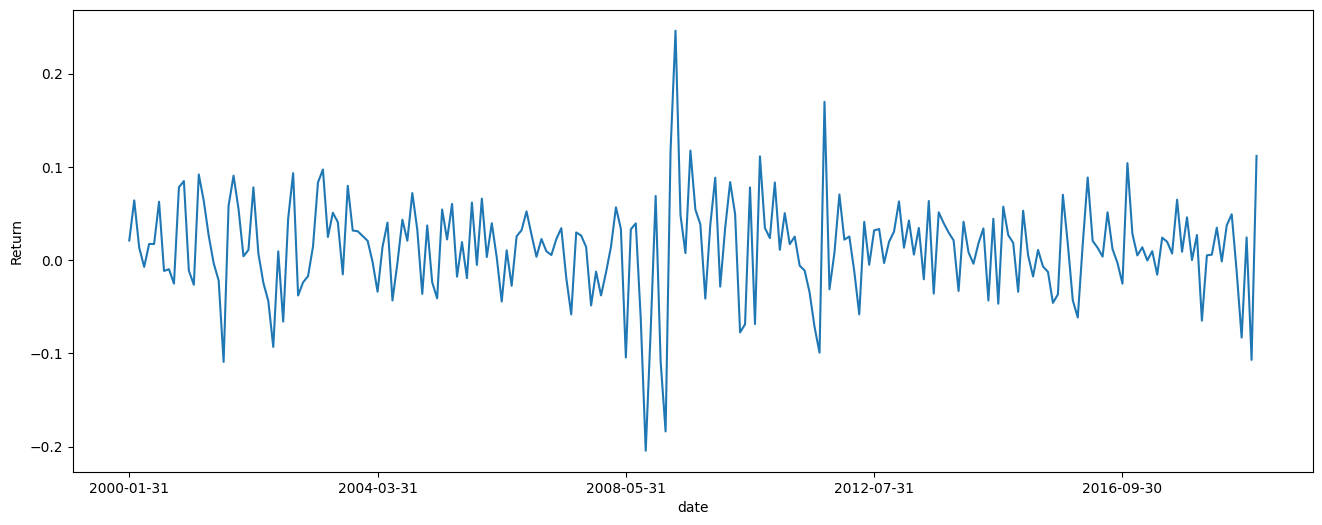

In [21]:
data_ml.groupby('date').mean()['R1M_Usd'].plot(figsize=[16,6], ylabel='Return')

2. 수식(12.3)에서 정의한 가중치 함수 코딩

In [22]:
def weights(Sigma, mu, Lambda, lamda, k_D, k_R, w_old):
    N = Sigma.shape[0]
    M = np.linalg.inv(lamda * Sigma + 2*k_R*Lambda + 2*k_D*np.eye(N))
    num = 1 - np.sum(M@(mu + 2*k_R*Lambda@w_old))
    den = np.sum(M@np.ones(N))
    eta = num / den
    vec = mu + eta * np.ones(N) + 2*k_R*Lambda@w_old
    return M@vec

3. 작은 백테스팅에서 이를 테스트하고 매개변수에 관한 민감도를 확인하라.

In [23]:
stock_ids_short = []
stock_days = []

# 각 주식별 데이터 포인트 개수 세기
stock_ids = data_ml['stock_id'].unique()
stock_days = data_ml[['date', 'stock_id']].groupby(
    ['stock_id']).count().reset_index()

# 데이터가 모두 있는 주식을 리스트로 변환
stock_ids_short = stock_days.loc[
    stock_days['date'] == (stock_days['date'].max())]
stock_ids_short = stock_ids_short['stock_id'].unique()
is_stock_ids_short = data_ml['stock_id'].isin(stock_ids_short)
returns = data_ml[is_stock_ids_short].pivot(
    index='date', columns='stock_id', values='R1M_Usd'
)

In [24]:
Sigma = returns.cov().values
mu = returns.mean(axis=0).values
Lambda = np.eye(Sigma.shape[0])
lamda = 1
k_D = 1
k_R = 1
w_old = np.ones(Sigma.shape[0]) / Sigma.shape[0]
weights(Sigma, mu, Lambda, lamda, k_D, k_R, w_old)[:5]

array([ 0.00313393, -0.00032435,  0.00119447,  0.00141942,  0.00150862])

In [25]:
#분산화 정도 , 레버리지, 표본 내 변동성
def sensi(lamda, k_D, Sigma, mu, Lambda, k_R, w_old):
    w = weights(Sigma, mu, Lambda, lamda, k_D, k_R, w_old)
    out = []
    out.append(1/np.sum(np.square(w)))
    out.append(w.T@Sigma@w)
    return out

In [27]:
lamda = np.power(10, np.arange(-3, 3, 1, dtype=float))
k_D = 2*np.power(10, np.arange(-3, 3, 1, dtype=float))
res = []
for i, j in itertools.product(lamda, k_D):
    res.append([i, j] + sensi(i, j, Sigma, mu, Lambda, k_R, w_old))
res = pd.DataFrame(res, columns=['lamda', 'k_D', 'div', 'lev', 'vol'])
res.set_index(['lamda', 'k_D']).plot(
    figsize=(14,12), subplots=True, sharey=False, sharex=True, kind='bar'
)

ValueError: 5 columns passed, passed data had 4 columns

[0.001, 0.002, 49.2286291344821, 0.041577428827943685]


array([<Axes: title={'center': 'div'}, xlabel='lamda,k_D'>,
       <Axes: title={'center': 'lev'}, xlabel='lamda,k_D'>], dtype=object)

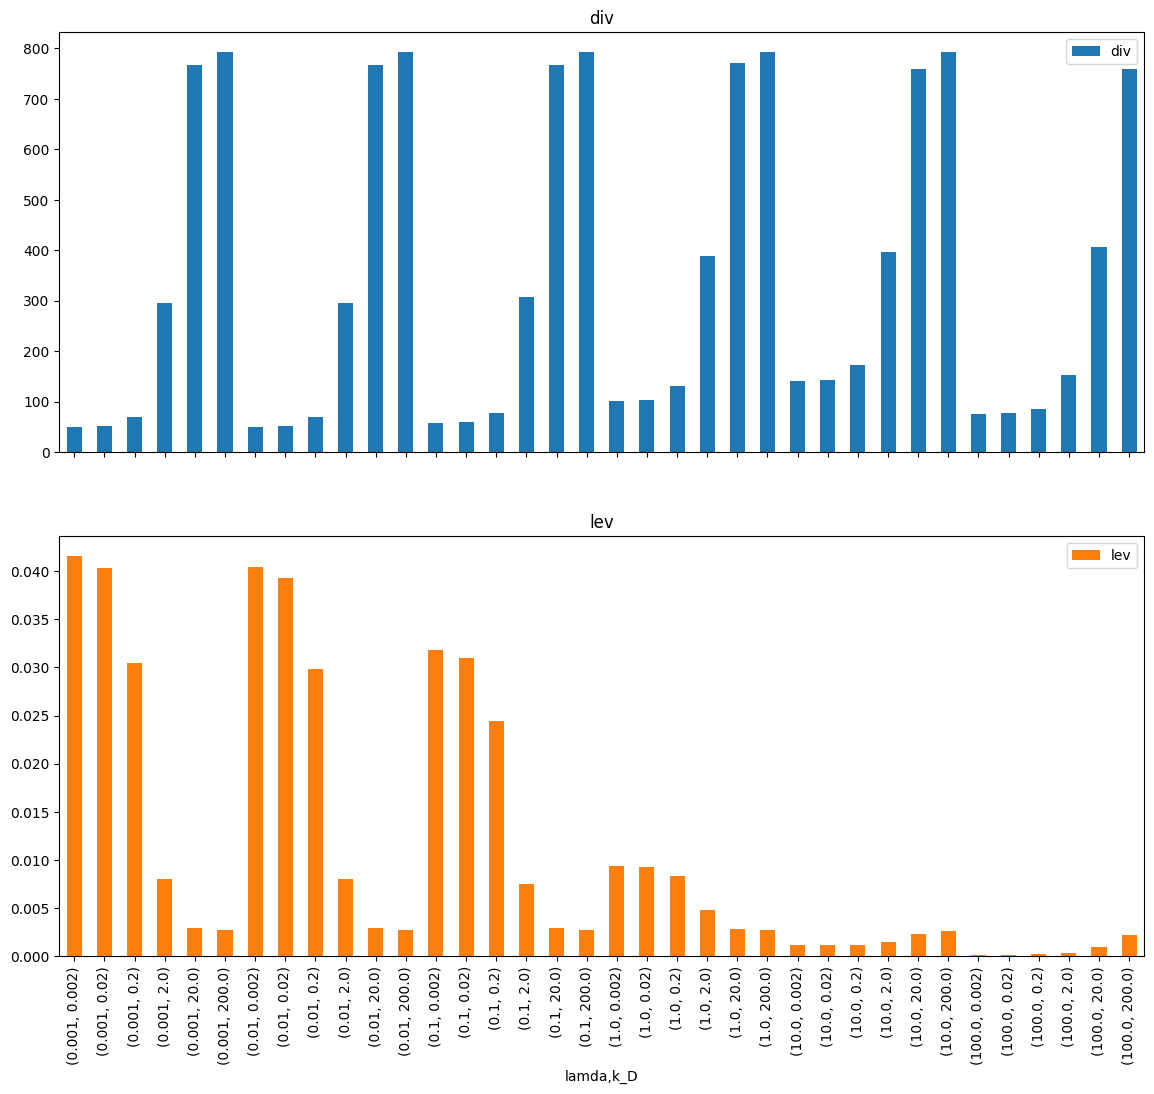

In [28]:
import pandas as pd
import numpy as np
import itertools

lamda = np.power(10, np.arange(-3, 3, 1, dtype=float))
k_D = 2 * np.power(10, np.arange(-3, 3, 1, dtype=float))
res = []

# sensi 함수와 Sigma, mu, Lambda, k_R, w_old 값 필요
for i, j in itertools.product(lamda, k_D):
    res.append([i, j] + sensi(i, j, Sigma, mu, Lambda, k_R, w_old))

# DataFrame 생성 전 데이터 확인
print(res[0])  # 각 행의 데이터 개수 확인
columns = ['lamda', 'k_D', 'div', 'lev', 'vol'][:len(res[0])]

# DataFrame 생성
res = pd.DataFrame(res, columns=columns)

# 플롯 그리기
res.set_index(['lamda', 'k_D']).plot(
    figsize=(14, 12), subplots=True, sharey=False, sharex=True, kind='bar'
)
